<a href="https://colab.research.google.com/github/ggyppsyy/colab_experiments/blob/master/OG_DCGan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
from torch.autograd import Variable
from torchvision.datasets import MNIST
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from PIL import Image
%matplotlib inline 


In [0]:
input_size = 784                    # The image size = 28 x 28 = 784
ndf = 64
ngf = 64
hidden_sizesD = [64,32,32,32,64,64]
hidden_sizesG = [64,32,64]   
num_epochs = 25                      
batch_size = 32                    
learning_rate = 1e-3
nc = 1
nz = 1000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
img_s = (1,64,64)
p = transforms.Compose([transforms.Resize((img_s[1],img_s[2])),transforms.ToTensor()])

train_dataset = MNIST(root='./data',
                           train=True,
                           transform=p,
                           download=True)

test_dataset = MNIST(root='./data',
                           train=False,
                           transform=p)

In [0]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [0]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [0]:
class Old_Discriminator(nn.Module):
    def __init__(self, input_size, hidden_sizes):
        super(Discriminator, self).__init__()
        self.hidden_sizes = hidden_sizes
        self.fc_layers = [nn.Linear(input_size, hidden_sizes[0]).to(device)]
        #self.bn_layers = [nn.BatchNorm2d(nc)]
        self.relu_layers = [nn.ReLU()]
        if (len(hidden_sizes) > 1):
            for i in range(1, len(hidden_sizes)):
                self.fc_layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]).to(device))
                #self.bn_layers = [nn.BatchNorm2d(nc)]
                self.relu_layers = [nn.ReLU()]
        self.final_dense = nn.Linear(hidden_sizes[len(hidden_sizes)-1], 1)
        self.sigmoid = nn.Sigmoid()

    
    def forward(self, x):                             
        inputs = x
        for i in range(len(self.hidden_sizes)):
            inputs = self.fc_layers[i](inputs)
        return self.sigmoid(self.final_dense(inputs))

In [0]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1).squeeze(1)


In [8]:
discriminator = Discriminator(1)
discriminator = discriminator.to(device)
discriminator.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
    (12): Sigmoid()
  )
)

In [0]:
class Old_Generator(nn.Module):
    def __init__(self, input_size, hidden_sizes):
        super(Generator, self).__init__()
        self.hidden_sizes = hidden_sizes
        self.fc_layers = [nn.Linear(int(input_size), hidden_sizes[0]).to(device)]
        #self.bn_layers = [nn.BatchNorm2d(nc)]
        self.relu_layers = [nn.ReLU()]
        if (len(hidden_sizes) > 1):
            for i in range(1, int(len(hidden_sizes))):
                self.fc_layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]).to(device))
                #self.bn_layers = [nn.BatchNorm2d(nc)]
                self.relu_layers = [nn.ReLU()]
        self.final_dense = nn.Linear(hidden_sizes[len(hidden_sizes)-1], input_size)
    
    def forward(self, x):                             
        inputs = x
        for i in range(int(len(self.hidden_sizes))):
            inputs = self.fc_layers[i](inputs)
        return self.final_dense(inputs)

In [0]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output


In [11]:
generator = Generator(1)
generator = generator.to(device)
generator.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(1000, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (13): Tanh()
  )
)

In [0]:
#criterion = nn.CrossEntropyLoss()
criterion =  nn.BCELoss()
optimizerD = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


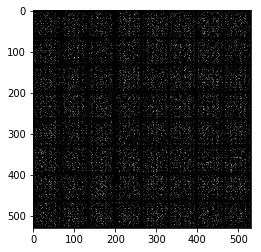

Epoch [1/25], Step [500/1875], Loss: 0.3545
Epoch [1/25], Step [1000/1875], Loss: 0.3617
Epoch [1/25], Step [1500/1875], Loss: 0.3444


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


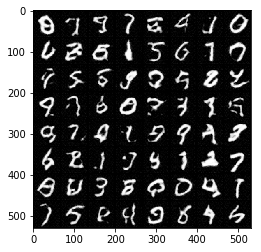

Epoch [2/25], Step [500/1875], Loss: 0.3624
Epoch [2/25], Step [1000/1875], Loss: 0.3496
Epoch [2/25], Step [1500/1875], Loss: 0.6003


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


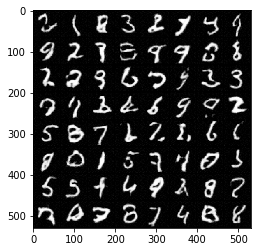

Epoch [3/25], Step [500/1875], Loss: 0.3422
Epoch [3/25], Step [1000/1875], Loss: 0.3565
Epoch [3/25], Step [1500/1875], Loss: 0.3424


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


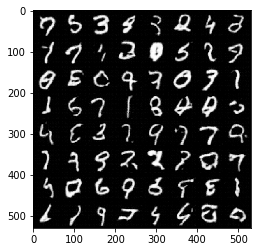

Epoch [4/25], Step [500/1875], Loss: 0.3477
Epoch [4/25], Step [1000/1875], Loss: 0.3317
Epoch [4/25], Step [1500/1875], Loss: 0.3347


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


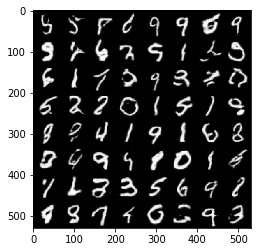

Epoch [5/25], Step [500/1875], Loss: 0.3446
Epoch [5/25], Step [1000/1875], Loss: 0.3317
Epoch [5/25], Step [1500/1875], Loss: 0.3724


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


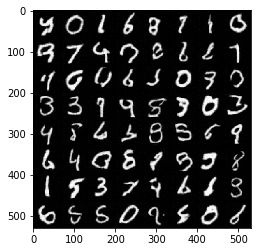

Epoch [6/25], Step [500/1875], Loss: 0.3314
Epoch [6/25], Step [1000/1875], Loss: 0.4048
Epoch [6/25], Step [1500/1875], Loss: 0.3414


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


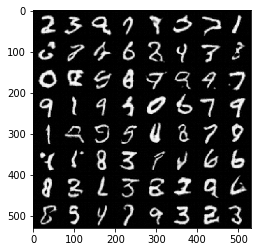

Epoch [7/25], Step [500/1875], Loss: 0.3479
Epoch [7/25], Step [1000/1875], Loss: 0.3344
Epoch [7/25], Step [1500/1875], Loss: 0.3377


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


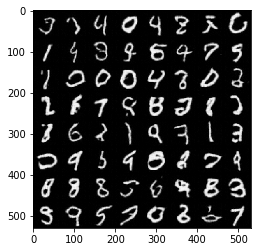

Epoch [8/25], Step [500/1875], Loss: 0.3307
Epoch [8/25], Step [1000/1875], Loss: 0.3291
Epoch [8/25], Step [1500/1875], Loss: 0.3316


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


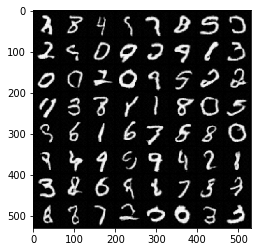

Epoch [9/25], Step [500/1875], Loss: 0.3369
Epoch [9/25], Step [1000/1875], Loss: 0.3353
Epoch [9/25], Step [1500/1875], Loss: 0.3283


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


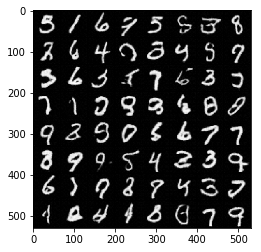

Epoch [10/25], Step [500/1875], Loss: 0.3277
Epoch [10/25], Step [1000/1875], Loss: 0.3338
Epoch [10/25], Step [1500/1875], Loss: 0.5671


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


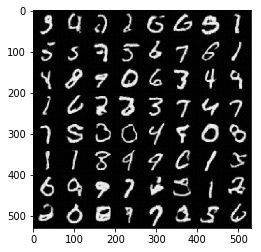

Epoch [11/25], Step [500/1875], Loss: 0.3521
Epoch [11/25], Step [1000/1875], Loss: 0.3366
Epoch [11/25], Step [1500/1875], Loss: 0.3275


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


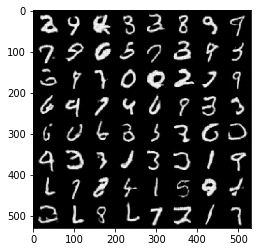

Epoch [12/25], Step [500/1875], Loss: 0.3277
Epoch [12/25], Step [1000/1875], Loss: 0.3300
Epoch [12/25], Step [1500/1875], Loss: 0.3273


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


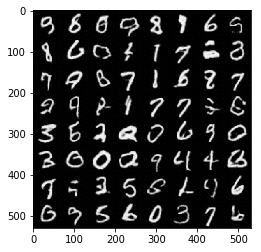

Epoch [13/25], Step [500/1875], Loss: 0.3265
Epoch [13/25], Step [1000/1875], Loss: 0.3303
Epoch [13/25], Step [1500/1875], Loss: 0.3291


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


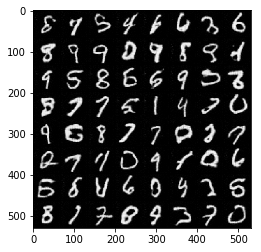

Epoch [14/25], Step [500/1875], Loss: 0.3297
Epoch [14/25], Step [1000/1875], Loss: 0.3278
Epoch [14/25], Step [1500/1875], Loss: 0.3319


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


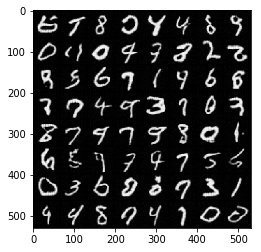

Epoch [15/25], Step [500/1875], Loss: 0.3269
Epoch [15/25], Step [1000/1875], Loss: 0.3450
Epoch [15/25], Step [1500/1875], Loss: 0.3266


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


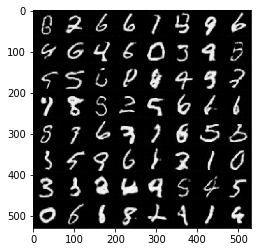

Epoch [16/25], Step [500/1875], Loss: 0.3296
Epoch [16/25], Step [1000/1875], Loss: 0.3273
Epoch [16/25], Step [1500/1875], Loss: 0.3343


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


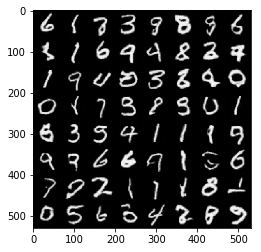

Epoch [17/25], Step [500/1875], Loss: 0.3261
Epoch [17/25], Step [1000/1875], Loss: 0.3276
Epoch [17/25], Step [1500/1875], Loss: 0.7251


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


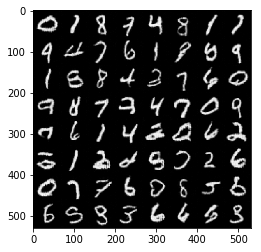

In [0]:
true_labels = torch.ones([batch_size])-0.1
true_labels = true_labels.to(device)
false_labels = torch.zeros([batch_size])+0.1
false_labels = false_labels.to(device)

'''for epoch in range(1):
    
    for i, (images,_) in enumerate(train_loader):
        images = Variable(images.view(-1,1,64,64)).to(device)
        
        optimizerD.zero_grad()
        gen_batch = torch.FloatTensor(np.random.randint(255, size=(batch_size, nz, 1, 1)).tolist()).to(device)
        predictions = generator(gen_batch)
        outputs = discriminator(images)
        outputs2 = discriminator(predictions)
        lossD = criterion(outputs, true_labels) + criterion(outputs2, false_labels)
        lossD.backward()
        optimizerD.step()
        
        if (i+1) % 100 == 0:
            print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
                 %(epoch+1, 1, i+1, len(train_dataset)//batch_size, lossD.data))
'''

for epoch in range(num_epochs):
    
    with torch.no_grad():
        gen_batch = torch.randn(batch_size*2, nz, 1, 1, device=device)
        predictions = generator(gen_batch)
        grid_img = torchvision.utils.make_grid(predictions, nrow=8).data.cpu().numpy()
        plt.imshow(grid_img.transpose(1,2,0))
        plt.show()
        #display(Image.fromarray(grid_img.transpose(1, 2, 0)))
    
    for i, (images,_) in enumerate(train_loader):
        images = Variable(images.view(-1,nc,img_s[1],img_s[2])).to(device)
        
        optimizerD.zero_grad()
        outputs = discriminator(images)
        lossD = criterion(outputs, true_labels)
        lossD.backward()
        optimizerD.step()
        
        gen_batch = torch.randn(batch_size, nz, 1, 1, device=device)
        predictions = generator(gen_batch)
        outputs = discriminator(predictions)
        lossD = criterion(outputs, false_labels)
        lossD.backward()
        optimizerD.step()
        
        optimizerG.zero_grad()
        gen_batch = torch.randn(batch_size, nz, 1, 1, device=device)
        predictions = generator(gen_batch)
        outputs = discriminator(predictions)
        lossG = criterion(outputs, true_labels)
        lossG.backward()
        optimizerG.step()
        
        
        if (i+1) % 500 == 0:
            print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, lossD.data))


In [0]:
torch.save(discriminator.state_dict(), 'fnn_D_model.pkl')
torch.save(generator.state_dict(), 'fnn_G_model.pkl')